# REACT Study Analysis

Using [data](https://github.com/mrc-ide/reactidd/tree/master/inst/extdata) from the [REACT Github repository](https://github.com/mrc-ide/reactidd) to identify periodic trends in Covid-19 case data.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import fftpack

import periodic_sampling as ps
from periodic_sampling.analysis import rel_reporting_calc, weekday_t_tests, multiple_comparisons_correction

In [2]:
# Read in and format data

tot_df = pd.read_csv('total.csv')
pos_df = pd.read_csv('positive.csv')

for df in [tot_df, pos_df]:
    df.rename(columns={df.columns.values[0]: 'Date'}, inplace=True)
    df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%d")
    df['Combined'] = df.sum(axis=1, numeric_only=True)
    df = ps.analysis.rel_reporting_calc(df, ['Combined'])
    df["Days"] = df["Date"].apply(lambda date: (date - min(df["Date"])).days)

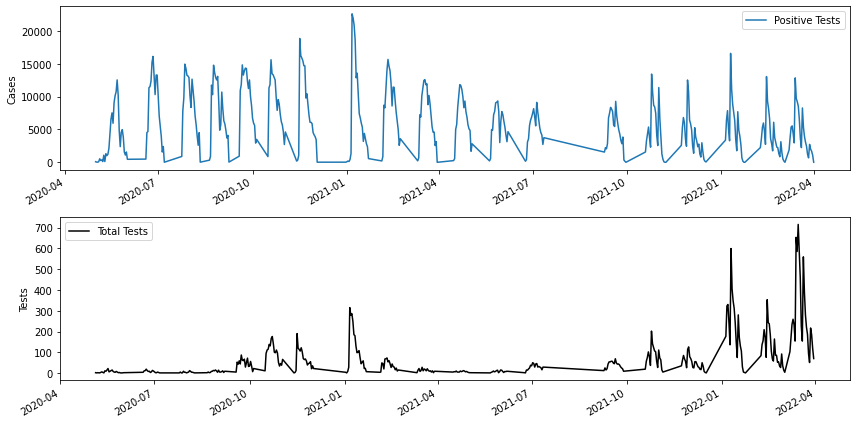

In [3]:
plt.rcParams['font.size'] = '16'
fig, axs = plt.subplots(2, 1, figsize=(12,6))

plot1 = tot_df.plot.line('Date', 'Combined', ax=axs[0], color='tab:blue', label='Positive Tests')
axs[0].set_xlabel(''); axs[0].set_ylabel('Cases')

plot2 = pos_df.plot.line('Date', 'Combined', ax=axs[1], color='black', label = 'Total Tests')
axs[1].set_xlabel(''); axs[1].set_ylabel('Tests')

fig.patch.set_facecolor('white') ; fig.tight_layout()
# plt.savefig(f"../images/react_survey/cases_over_time.png")

Note there are a number of gaps in the data - we will ignore these in subsequent analysis

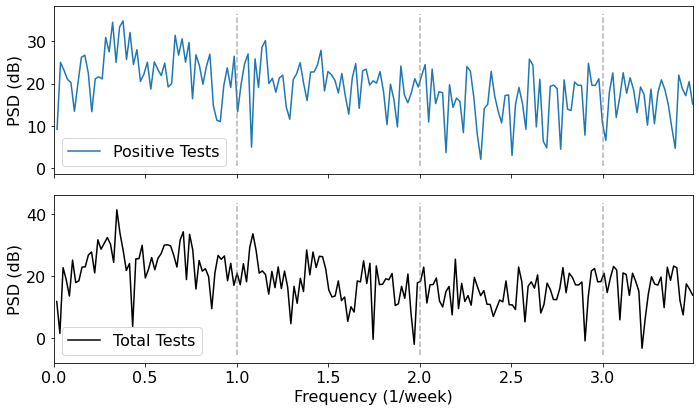

In [4]:
plt.rcParams['font.size'] = '16'
fig, axs = plt.subplots(2, 1, figsize=(10,6))

case_fft_pub, case_freq_pub = ps.analysis.fourier_transform(pos_df, column='Dif_Combined', compute_psd=True)
ps.analysis.plot_fft(case_fft_pub, case_freq_pub, ax=axs[0], color='tab:blue', label="Positive Tests")
axs[0].set_xlabel(''); axs[0].set_xticklabels([])

test_fft_pub, test_freq_pub = ps.analysis.fourier_transform(tot_df, column='Dif_Combined', compute_psd=True)
ps.analysis.plot_fft(test_fft_pub, test_freq_pub, ax=axs[1], color='black', label="Total Tests")

fig.patch.set_facecolor('white'); fig.tight_layout()
# plt.savefig(f"../images/react_survey/daily_fft_cases_tests.png")


In [5]:
total_half = tot_df.copy(); pos_half = pos_df.copy()
total_half.rename(columns={'Combined': 'Total Cases'}, inplace = True)
pos_half.rename(columns={'Combined': 'Positive Cases'}, inplace = True)
df = pd.merge(
    left = total_half[['Date', 'Total Cases']],
    right = pos_half[['Date', 'Positive Cases']],
    on = 'Date',
    how = 'outer'
)

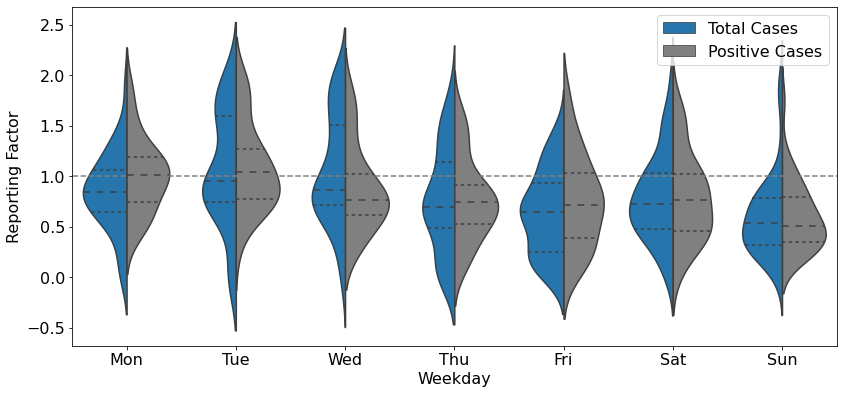

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
ps.analysis.rel_reporting_violin(df.copy(), ['Total Cases', 'Positive Cases'],  ax=ax, cutoff=2,
                   colors=['tab:blue', 'grey'], labels=["Total Cases", "Positive Cases"])  

for i in range(2):
    ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])  
plt.xlabel('Weekday'); ax.set_ylabel("Reporting Factor"); 
plt.suptitle(''); fig.patch.set_facecolor('white'); plt.tight_layout()
# plt.savefig(f"../images/uk_phe_data/daily_violin_cases_deaths.png")

In [9]:
df['Positivity'] = df['Positive Cases'] / df['Total Cases']
df = ps.analysis.rel_reporting_calc(df, ['Total Cases', 'Positive Cases', 'Positivity'])

['Date' 'Total Cases' 'Positive Cases' 'Positivity' 'Day_Index' 'Weekday'
 'Dif_Total Cases' 'Dif_Positive Cases' 'Dif_Positivity']


In [10]:
def _my_print(list, print_output = True):
    output = [float('%.2g' % x) for x in list]
    return output if not print_output else print(output)

def print_weekday_tests(df, col):
    print("Test results for column: " + col)
    print("  T-test stat: " + str(_my_print(weekday_t_tests(df, col, p_vals = False), print_output=False)))
    print("  p values:    " + str(_my_print(weekday_t_tests(df, col, p_vals = True), print_output=False)))
    print("  Accept H0:   " + str(multiple_comparisons_correction(weekday_t_tests(df, col), 0.01)))

print_weekday_tests(df, 'Dif_Positive Cases')
print_weekday_tests(df, 'Dif_Total Cases')
print_weekday_tests(df, 'Dif_Positivity')

Test results for column: Dif_Positive Cases
  T-test stat: [2.9, 2.2, 0.13, -1.5, -2.5, -1.4, -5.1]
  p values:    [0.0051, 0.033, 0.89, 0.15, 0.017, 0.18, 4e-06]
  Accept H0:   [True, True, True, True, True, True, False]
Test results for column: Dif_Total Cases
  T-test stat: [3.3, 2.4, 2.2, 0.096, -1.9, 0.77, -2.1]
  p values:    [0.0016, 0.021, 0.034, 0.92, 0.062, 0.44, 0.041]
  Accept H0:   [True, True, True, True, True, True, True]
Test results for column: Dif_Positivity
  T-test stat: [0.5, 1.1, -0.93, 0.73, -0.18, 1.7, 1.1]
  p values:    [0.62, 0.26, 0.36, 0.47, 0.85, 0.1, 0.26]
  Accept H0:   [True, True, True, True, True, True, True]
